In [7]:
# Import modules
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import os
import sys
import pickle
import math
from datetime import datetime, timedelta
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator, AutoLocator, FuncFormatter, MultipleLocator
from matplotlib import cm

# Import custom py modules for post-processing
sys.path.insert(0,"./python-scripts")
from ab209_module import map_plot, overheating_hours, add_AC, overheating_hours_tab, overheating_eval
sys.path.insert(0, "./epw-master/epw")
from epw import epw

# Set global font properties
plt.style.use('default')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16

In [37]:
# Read meta data and define file paths
main_folder = "H:/My Drive/(01) BSTS Berkeley/(5) Research/AB 209/Data Analysis Python (Current)/"
metadata_directory = os.path.join(main_folder, "ca-baseline-sample-50k-modified.csv")
figure_directory = os.path.join(main_folder, "plots")
table_directory = os.path.join(main_folder, "tables")
county_shapefile_directory = os.path.join(main_folder, "ca-map/ca-county-boundaries/CA_Counties_TIGER2016.shp")
state_shapefile_directory = os.path.join(main_folder, "ca-map/ca-state-boundary/CA_State_TIGER2016.shp")
metadata = pd.read_csv(metadata_directory)

# Get county names
metadata['County'] = metadata['County'].apply(lambda x: x.split('CA, ')[1].split(' County')[0])

# Get building IDs by county
building_ids_by_county = metadata.groupby('County')['Building'].unique().to_dict()

# Condition to filter buildings without AC
building_ids_without_ac = metadata['HVAC Cooling Type'].isnull()
building_ids_without_ac_by_county = metadata.loc[building_ids_without_ac,:].groupby('County')['Building'].unique().to_dict()

# Condition to filter buildings with AC
building_ids_with_ac = metadata['HVAC Cooling Type'].notnull()
building_ids_with_ac_by_county = metadata.loc[building_ids_with_ac, :].groupby('County')['Building'].unique().to_dict()

# AC prevalence by county
ac_count = metadata.loc[building_ids_without_ac, 'County'].value_counts().reset_index()

# Count all buildings across each county
sample_count = metadata['County'].value_counts().reset_index().rename(columns = {'count':'total'})

# Merge dataframes
ac_count = ac_count.merge(sample_count, how = 'left', on = 'County')

# Calculate the percentage of buildings that have AC across each county
ac_count['Value'] = 1- ac_count['count'].div(ac_count['total'])

In [3]:
# ---------------------------------------------------------------------------------------------------------------------------------------------------- #
# Load baseline simulation result data
# ---------------------------------------------------------------------------------------------------------------------------------------------------- #

# Cooling energy use
cooling_energy_df = pd.read_pickle(os.path.join(main_folder, 'simulation-results/cool_AC_new_df.pickle'))
cooling_energy_df['Time'] = cooling_energy_df['Time'].str.strip().apply(lambda x: '1991/'+ str(x))
cooling_energy_df['Time'] = cooling_energy_df['Time']
mark_index = cooling_energy_df['Time'].str.endswith('24:00:00')     # Correct 24:00 to 00:00 next day
cooling_energy_df['Time'] = cooling_energy_df['Time'].str.replace('24:00:00', '00:00:00')
cooling_energy_df.loc[mark_index, 'Time'] = (pd.to_datetime(cooling_energy_df.loc[mark_index, 'Time'], 
                                                            format = '%Y/%m/%d %H:%M:%S') + pd.Timedelta(days = 1)).dt.strftime('%Y/%m/%d %H:%M:%S')
timeseries = cooling_energy_df['Time']
cooling_energy_df = cooling_energy_df.set_index('Time')

# Indoor temperature
indoor_temperature_df = pd.read_pickle(os.path.join(main_folder, 'simulation-results/temp_new_df.pickle'))
indoor_temperature_df.index = timeseries

# ---------------------------------------------------------------------------------------------------------------------------------------------------- #
# Add ACs to no-AC buildings
# ---------------------------------------------------------------------------------------------------------------------------------------------------- #

# Cooling energy use
cooling_energy_all_AC_df = pd.read_pickle(os.path.join(main_folder, 'simulation-results/allAC_cool_AC_new_df.pickle'))
cooling_energy_all_AC_df['Time'] = timeseries
cooling_energy_all_AC_df = cooling_energy_all_AC_df.set_index('Time')

# Indoor temperature
indoor_temperature_all_AC_df = pd.read_pickle(os.path.join(main_folder, 'simulation-results/allAC_temp_new_df.pickle'))
indoor_temperature_all_AC_df.index = timeseries

In [19]:
# Get CA weather files
current_weather_metadata = os.path.join(main_folder, "ca-weather-files.csv")
current_weather_files = os.path.join(main_folder, "modified-tmy-files")

# EPW reader
a = epw()

# Current weather files
windspd_df = pd.DataFrame()
oat_df = pd.DataFrame()

for index, row in current_weather_metadata.iterrows():
    epw_file = row['county_id'] + '.epw'
    epw_path = os.path.join(current_weather_files, epw_file)
    a.read(epw_path)
    df = a.dataframe 
    county = row['county_name'].split(',')[1].split('County')[0].strip()
    windspd_df[county] = df.loc[(df['Month'] >= 5) & (df['Month'] <= 10), 'Wind Speed']
    oat_df[county] = df.loc[(df['Month'] >= 5) & (df['Month'] <= 10), 'Dry Bulb Temperature']
    
# wind speed boxplot
plt.figure(figsize=(18, 6))
windspd_df.boxplot()
plt.xticks(rotation=90, fontsize = 12)
plt.ylabel("Wind Speed", fontsize = 16)
plt.title('May 1 to Oct 31', fontsize = 18)
plt.show()

# oat boxplot
plt.figure(figsize=(18, 6))
oat_df.boxplot()
plt.xticks(rotation=90, fontsize = 12)
plt.ylabel("Outdoor Air Dry Bulb Temperature", fontsize = 16)
plt.title('May 1 to Oct 31', fontsize = 18)
plt.show()

NameError: name 'EPW' is not defined

### Housing Characteristics

In [1]:
# Replace "None" in 'HVAC Cooling Type' column with 'No AC'
metadata['HVAC Cooling Type'] = metadata['HVAC Cooling Type'].fillna('No AC')
metadata['Vintage ACS'] = metadata['Vintage ACS'].replace('2010s', ">2009")

# Calculate frequencies and percentages for each category
building_year = metadata['Vintage ACS'].value_counts(normalize = True).mul(100).rename_axis('Building Year').reset_index(name = 'Percentage')
building_type = metadata['Geometry Building Type RECS'].value_counts(normalize = True).mul(100).rename_axis('Building Type').reset_index(name = 'Percentage')
hvac_type = metadata['HVAC Cooling Type'].value_counts(normalize = True).mul(100).rename_axis('HVAC Type').reset_index(name = 'Percentage')
ca_counties = metadata['County'].value_counts(normalize = True).mul(100).rename_axis('County').reset_index(name = 'Percentage')

# Reorder and categorize the building years
year_order = ['<1940', '1940-59', '1960-79', '1980-99', '2000-09', '>2009']
building_year['Building Year'] = pd.Categorical(building_year['Building Year'], categories = year_order, ordered = True)
building_year = building_year.sort_values('Building Year')

# Reorder and categorize the HVAC types
hvac_order = ['Central AC', 'Room AC', 'Heat Pump', 'No AC']
hvac_type['HVAC Type'] = pd.Categorical(hvac_type['HVAC Type'], categories = hvac_order, ordered = True)
hvac_type = hvac_type.sort_values('HVAC Type')

# Reorder and categorize the building types
building_order = ['Single-Family Detached', 'Single-Family Attached', 'Multi-Family with 2 - 4 Units', 'Multi-Family with 5+ Units', 'Mobile Home']
building_type['Building Type'] = pd.Categorical(building_type['Building Type'], categories = building_order, ordered = True)
building_type = building_type.sort_values('Building Type')

# Handle possible NaNs explicitly if any mismatch
building_year = building_year.dropna()

# Combine smaller counties into "Others"
top_10 = ca_counties.nlargest(10, 'Percentage')
others = ca_counties[~ca_counties['County'].isin(top_10['County'])]
others_sum = others['Percentage'].sum()
others_row = pd.DataFrame({'County': ['Others (48)'], 'Percentage': [others_sum]})
ca_counties = pd.concat([top_10, others_row])

# Correct formatting for building types
building_type['Building Type'] = building_type['Building Type'].replace({
    'Multi-Family with 2 - 4 Units': 'Multi-\nFamily\n(2-4 Units)',
    'Multi-Family with 5+ Units': 'Multi-\nFamily\n(5+ Units)',
    'Single-Family Attached': 'Single-\nFamily\nAttached',
    'Single-Family Detached': 'Single-\nFamily\nDetached'
})

# Create subplots
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (14.4, 7.2))

# Adjust the appearance of the tick marks    
for ax in axes.flatten():
    ax.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = True, color = 'black', width = 0.5)
    ax.tick_params(axis = 'y', which = 'both', left = True, right = False, labelleft = True, color = 'black', width = 0.5)

# Plot Building Type
axes[0, 0].bar(building_type['Building Type'], building_type['Percentage'], color = '#3B7EA1')
axes[0, 0].set_ylim(0, 60)
axes[0, 0].set_yticks(range(0, 61, 20))
axes[0, 0].tick_params(axis = 'x', rotation = 0)
axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))

# Plot HVAC Type
axes[0, 1].bar(hvac_type['HVAC Type'], hvac_type['Percentage'], color = '#3B7EA1')
axes[0, 1].set_ylim(0, 60)
axes[0, 1].set_yticks(range(0, 61, 20))
axes[0, 1].tick_params(axis = 'x', rotation = 0)
axes[0, 1].tick_params(axis = 'y', labelleft = False)
axes[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))

# Plot Building Year
axes[1, 0].bar(building_year['Building Year'], building_year['Percentage'], color = '#3B7EA1')
axes[1, 0].set_ylim(0, 40)
axes[1, 0].set_yticks(range(0, 41, 10))
axes[1, 0].tick_params(axis = 'x', rotation = 0)
axes[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))

# Plot California Counties
ca_counties_sorted = ca_counties.sort_values('Percentage', ascending = False)
axes[1, 1].bar(ca_counties_sorted['County'], ca_counties_sorted['Percentage'], color = '#3B7EA1')
axes[1, 1].set_ylim(0, 40)
axes[1, 1].set_yticks(range(0, 41, 10))
labels = [label.get_text() for label in axes[1, 1].get_xticklabels()]
axes[1, 1].set_xticks(axes[1, 1].get_xticks())
axes[1, 1].set_xticklabels(labels, rotation = 45, ha = 'right')
axes[1, 1].tick_params(axis = 'y', labelleft = False)
axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))

# Adjust the appearance of the tick marks
for ax in axes.flatten():
    ax.tick_params(axis = 'x', color = '#848484', width = 0.5)
    ax.tick_params(axis = 'y', color = '#848484', width = 0.5)

# Add titles
titles = ['(a)', '(b)', '(c)', '(d)']
'''titles = ['Sample Distribution by Building Type', 'Sample Distribution by HVAC Type', 'Sample Distribution by Building Year', 'Sample Distribution by County']'''
for ax, title in zip(axes.flatten(), titles):
    ax.set_title(title, fontsize = 20, pad = 15)

# Remove the border lines and add custom grid lines
for ax in axes.flatten():
    ax.spines['top'].set_visible(True)
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['top'].set_color('#848484')
    ax.spines['top'].set_alpha(1)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('#848484')
    ax.spines['bottom'].set_alpha(1)
    ax.grid(axis = 'y', color = '#848484', linestyle = '-', linewidth = 0.5, alpha = 1)

# Adjust plot layout
plt.tight_layout(pad = 1, h_pad = 1.5, w_pad = -1)

# Save the plot with high DPI
plot_name = "housing-characteristics-v2.png"
save_path = os.path.join(figure_directory, plot_name)
plt.savefig(save_path, dpi = 600, bbox_inches = 'tight', format = 'png')

# Show plot
plt.show()

NameError: name 'metadata' is not defined

### Estimate the Total Cooling Energy Load in California

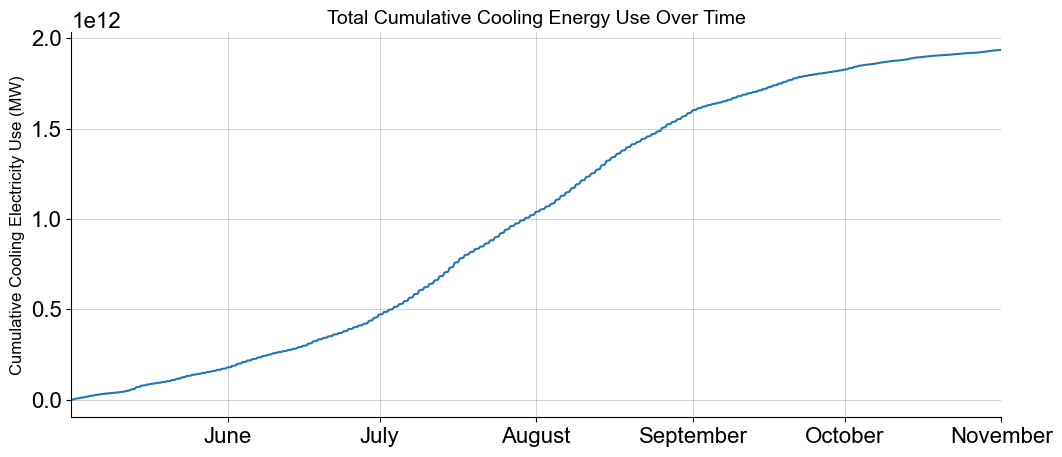

In [4]:
# Convert the table index to datetime format
cooling_energy_modified_df = cooling_energy_df
cooling_energy_modified_df.index = pd.to_datetime(cooling_energy_modified_df.index, format='%Y/%m/%d %H:%M:%S')

# Calculate total cumulative cooling energy use
cumulative_cool_energy = cooling_energy_modified_df.sum(axis = 1).cumsum()
scaling_factor = 14392140 * (10**6) / 52218 / 1000
cumulative_cool_energy_scaled = cumulative_cool_energy * scaling_factor

# Create DataFrame for cumulative cooling energy and scale the cooling energy use
cumulative_cool_energy_df = cumulative_cool_energy_scaled.reset_index()
cumulative_cool_energy_df.columns = ['Timestamp', 'CumulativeCoolingEnergy']

# Create plot for cumulative cooling energy use
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(cumulative_cool_energy_df['Timestamp'], cumulative_cool_energy_df['CumulativeCoolingEnergy'])
ax.set_xlim(cumulative_cool_energy_df['Timestamp'].min(), cumulative_cool_energy_df['Timestamp'].max())

# Set x-tick marks for the start of each month
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))

# Add labels and title
ax.set_ylabel('Cumulative Cooling Electricity Use (MW)', fontsize = 12)
ax.set_title('Total Cumulative Cooling Energy Use Over Time', fontsize = 14)

# Remove the border lines and add custom grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(axis = 'y', color = 'gray', linestyle = '-', linewidth = 0.5, alpha = 0.5)
plt.grid(axis = 'x', color = 'gray', linestyle = '-', linewidth = 0.5, alpha = 0.5)

# Display the plot
plt.show()

### Estimate the Peak Cooling Energy Load in California

Plot saved to: H:/My Drive/(01) BSTS Berkeley/(5) Research/AB 209/Data Analysis Python (Current)/plots\peak-week-cooling-energy.png


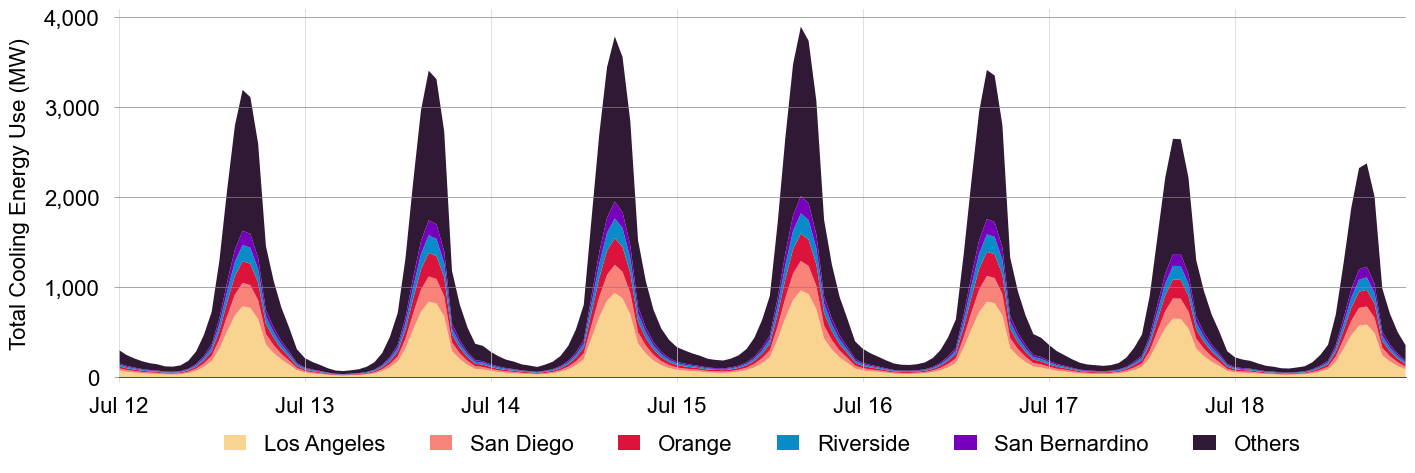

CA cooling peak load = 3894.30636287269 MW
Peak load on 07-15 18:00 DST


In [104]:

# ----------------------------------------------------------------------------------------------------------------------------- #
# Calculate and plot the peak cooling energy load
# ----------------------------------------------------------------------------------------------------------------------------- #

# Identify the peak week
cool_energy_total = cooling_energy_modified_df.sum(axis = 1)
peak_cooling = max(cool_energy_total)
peak_timestamp = cool_energy_total.idxmax()
peak_timeseries = pd.Timestamp(cool_energy_total.idxmax()).strftime('%Y/%m/%d')
peak_hour = pd.Timestamp(cool_energy_total.idxmax()).hour
delta = 3
three_days_before = pd.to_datetime(peak_timeseries, format = '%Y/%m/%d') - pd.Timedelta(days = delta)
three_days_after = pd.to_datetime(peak_timeseries, format = '%Y/%m/%d') + pd.Timedelta(days = delta + 1)
cond1 = cool_energy_total.index > three_days_before.strftime('%Y/%m/%d')
cond2 = cool_energy_total.index < three_days_after.strftime('%Y/%m/%d')
peak_week = cool_energy_total[cond1 & cond2]

# Identify the top 5 counties by the number of samples
county_counts = metadata['County'].value_counts()
top_5_counties = county_counts.index[:5]

# Remove the 'CA' proceeding and the 'County' suceeding the county name
top_5_counties_simple = top_5_counties.str.replace('CA, ', '').str.replace(' County', '')

# Group the cooling energy data by county
cooling_energy_modified_grouped_df = cooling_energy_modified_df.T.groupby(metadata['County']).sum().T

# Sum the cooling energy for the top 5 counties and group the remaining counties
top_5_cooling_df = cooling_energy_modified_grouped_df[top_5_counties]
other_cooling_df = cooling_energy_modified_grouped_df.drop(columns = top_5_counties).sum(axis = 1)
other_cooling_df.name = 'Others'
top_5_cooling_df = top_5_cooling_df.join(other_cooling_df)

# Filter the peak week data
peak_week_top_5 = top_5_cooling_df.loc[cond1 & cond2]

# Scale the cooling energy use according to the formula
scaling_factor = 14392140 / 52218 / 1000
peak_week_top_5_scaled = peak_week_top_5 * scaling_factor

# Create plot with shaded areas
timeseries_tick_label = [x.strftime('%b %d') for x in peak_week.index]
fig, ax = plt.subplots(figsize = (14.4, 5))

# Plot the contribution of each county
# colors = ["#4afff0", "#34bdcc", "#4f61a1", "#461e78", "#440a4f", "#301934"]
colors = ["#F9D491",    # gold
          "#F88379",    # coral
          "#DC143C",    # red
          "#078BC9",    # azure
          "#7600BC",    # violet
          "#301934"     # dark purple
          ]
labels = list(top_5_counties_simple) + ['Others']
ax.stackplot(peak_week.index, peak_week_top_5_scaled.T, labels = labels, colors = colors, alpha = 1, linewidth = 0)
ax.set_xlim(peak_week.index.min(), peak_week.index.max())
ax.set_xticks(peak_week.index[::24])
ax.set_xticklabels(timeseries_tick_label[::24], rotation = 0)
ax.set_ylabel('Total Cooling Energy Use (MW)', fontsize = 16, labelpad = 10)
ax.tick_params(axis = 'x', which = 'both', bottom = True, top = False, labelbottom = True, color = '#D3d3d3', width = 0.5, pad = 10)
ax.tick_params(axis = 'y', which = 'both', left = True, right = False, labelleft = True, color = '#848484', width = 0.5, pad = 10)

# Function to format the y-axis labels with commas
def format_ticks(x, pos):
    '''formats the labels with commas and no decimal places'''
    return '{:,.0f}'.format(x)

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Remove the border lines and add custom grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['bottom'].set_linewidth(0.5)
ax.grid(axis = 'x', color = '#D3d3d3', linestyle = '-', linewidth = 0.5, zorder = 0)
ax.grid(axis = 'y', color = '#848484', linestyle = '-', linewidth = 0.5, zorder = 0)

# Add legend and title
ax.legend(loc = 'upper left', fontsize = 16)
# ax.set_title('Contribution to Peak Cooling Energy Use by County', fontsize = 20, pad = 10)

# Add legend at the bottom in a single line
plt.legend(loc = 'upper center', 
           bbox_to_anchor = (0.5, -0.1), 
           ncol = 6, 
           fontsize = 16, 
           frameon = False, 
           handlelength = 1)

# Adjust plot
plt.tight_layout(pad = 1)

# Save the plot with high DPI
plot_name = "peak-week-cooling-energy.png"
save_path = os.path.join(figure_directory, plot_name)
plt.savefig(save_path, dpi = 600, bbox_inches = 'tight', format = 'png')
print(f"Plot saved to: {save_path}")

# Display the plot
plt.show()

# Scale and display the peak cooling energy load
estimated_peak_cooling = peak_cooling / 1000 * 14392140 / 52218
print(f'CA cooling peak load = {estimated_peak_cooling} MW')

# Display the date and time that the peak cooling load occurs
print(f'Peak load on {peak_timestamp.strftime("%m-%d")} {peak_timestamp.hour + 1}:00 DST')

Plot saved to: H:/My Drive/(01) BSTS Berkeley/(5) Research/AB 209/Data Analysis Python (Current)/plots\peak-day-cooling-energy.png


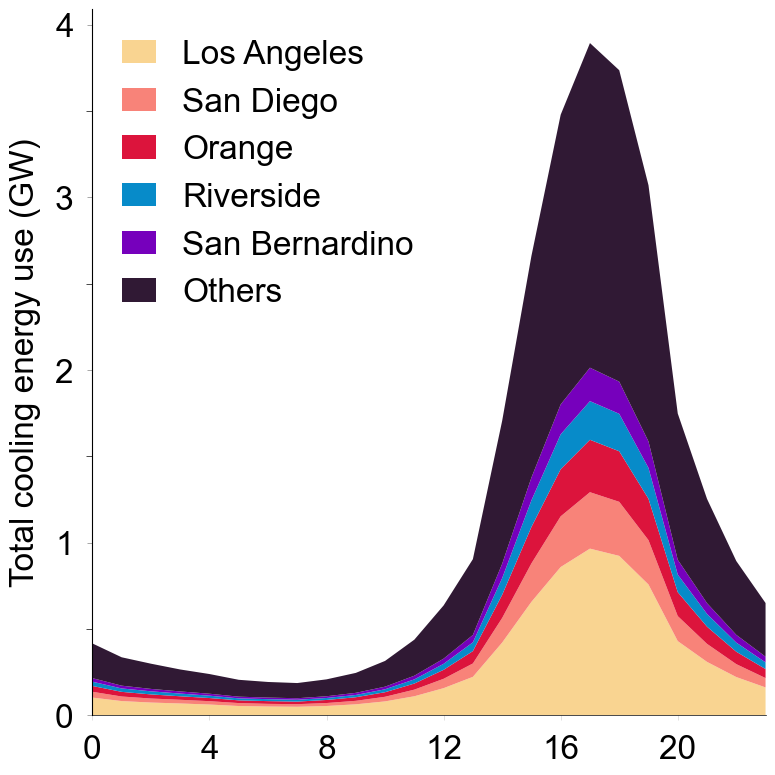

In [43]:

# ----------------------------------------------------------------------------------------------------------------------------- #
# Calculate and plot the peak cooling energy load
# ----------------------------------------------------------------------------------------------------------------------------- #

# Identify the peak day
cool_energy_total = cooling_energy_modified_df.sum(axis = 1)
peak_cooling = max(cool_energy_total)
peak_timestamp = cool_energy_total.idxmax()
peak_timeseries = pd.Timestamp(peak_timestamp).strftime('%Y-%m-%d')
start_of_day = pd.Timestamp(peak_timeseries)                                            # Start of the peak day (00:00)
end_of_day = pd.Timestamp(peak_timeseries) + pd.Timedelta(hours = 23, minutes = 59)     # End of peak day (23:59)
cond1 = cool_energy_total.index >= start_of_day
cond2 = cool_energy_total.index <= end_of_day
peak_day = cool_energy_total[cond1 & cond2]

# Identify the top 5 counties by the number of samples
county_counts = metadata['County'].value_counts()
top_5_counties = county_counts.index[:5]

# Remove the 'CA' proceeding and the 'County' suceeding the county name
top_5_counties_simple = top_5_counties.str.replace('CA, ', '').str.replace(' County', '')

# Group the cooling energy data by county
cooling_energy_modified_grouped_df = cooling_energy_modified_df.T.groupby(metadata['County']).sum().T

# Sum the cooling energy for the top 5 counties and group the remaining counties
top_5_cooling_df = cooling_energy_modified_grouped_df[top_5_counties]
other_cooling_df = cooling_energy_modified_grouped_df.drop(columns = top_5_counties).sum(axis = 1)
other_cooling_df.name = 'Others'
top_5_cooling_df = top_5_cooling_df.join(other_cooling_df)

# Filter the peak week data
peak_day_top_5 = top_5_cooling_df.loc[cond1 & cond2]

# Scale the cooling energy use according to the formula
scaling_factor = 14392140 / 52218 / 10 ** 6
peak_day_top_5_scaled = peak_day_top_5 * scaling_factor

# Create plot with shaded areas
timeseries_tick_label = [x.hour for x in peak_day.index]
fig, ax = plt.subplots(figsize = (8, 8))

# Plot the contribution of each county
# colors = ["#4afff0", "#34bdcc", "#4f61a1", "#461e78", "#440a4f", "#301934"]
colors = ["#F9D491",    # gold
          "#F88379",    # coral
          "#DC143C",    # red
          "#078BC9",    # azure
          "#7600BC",    # violet
          "#301934"     # dark purple
          ]
# labels = [label.replace(' ', '\n') for label in list(top_5_counties_simple)] + ['Others']
labels = list(top_5_counties_simple) + ['Others']
ax.stackplot(peak_day.index, peak_day_top_5_scaled.T, labels = labels, colors = colors, alpha = 1, linewidth = 0)
ax.set_xlim(peak_day.index.min(), peak_day.index.max())
ax.set_xticks(peak_day.index[::4])
ax.set_xticklabels(timeseries_tick_label[::4], rotation = 0)
ax.set_ylabel('Total cooling energy use (GW)', fontsize = 24, labelpad = 10)

# Function to format the y-axis labels with commas
def format_ticks(x, pos):
    '''formats the labels with commas and no decimal places'''
    return '{:,.0f}'.format(x)

ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))   # Apply the formatter to the y-axis
ax.yaxis.set_major_locator(MultipleLocator(1))              # Major ticks at 1 unit intervals
ax.yaxis.set_minor_locator(MultipleLocator(0.5))            # Minor ticks at 0.5 unit intervals

# Display ticks
ax.tick_params(axis = 'x', which = 'both', bottom = True, top = False, labelbottom = True, color = '#D3d3d3', width = 0.5, pad = 10, labelsize = 24)
ax.tick_params(axis = 'y', which = 'both', left = True, right = False, labelleft = True, color = '#848484', width = 0.5, pad = 10, labelsize = 24)
ax.tick_params(axis = 'y', which = 'minor', length = 4, color = 'black', labelleft = False, labelsize = 24)

# Remove the border lines and add custom grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['bottom'].set_linewidth(0.5)
# ax.grid(axis = 'x', which = 'both', color = '#D3d3d3', linestyle = '-', linewidth = 0.5, zorder = 0)
# ax.grid(axis = 'y', which = 'both', color = '#848484', linestyle = '-', linewidth = 0.5, zorder = 0)

# Add legend and title
ax.legend(loc = 'upper left', fontsize = 24)
# ax.set_title('Contribution to Peak Cooling Energy Use by County', fontsize = 20, pad = 10)

# Add legend at the bottom in a single line
plt.legend(loc = 'upper left', 
           ncol = 1, 
           fontsize = 24, 
           frameon = False,
           handlelength = 1)

# Adjust plot
plt.tight_layout(pad = 1)

# Save the plot with high DPI
plot_name = "peak-day-cooling-energy.png"
save_path = os.path.join(figure_directory, plot_name)
plt.savefig(save_path, dpi = 600, bbox_inches = 'tight', format = 'png')
print(f"Plot saved to: {save_path}")

# Display the plot
plt.show()

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------------- #
# Generate DataFrame showing peak load by county
# ----------------------------------------------------------------------------------------------------------------------------- #

# Identify the peak week by county
peak_week_by_county = cooling_energy_modified_grouped_df.loc[cond1 & cond2]

# Scale the cooling energy use according to the formula
scaling_factor = 14392140 / 52218 / 1000
peak_week_by_county_scaled = peak_week_by_county * scaling_factor

# Reset the index to turn 'Time' into a column
peak_week_by_county_scaled.reset_index(inplace = True)

# Remove "CA" and "County" from column names
peak_week_by_county_scaled.columns = peak_week_by_county_scaled.columns.str.replace('CA, ', '').str.replace(' County', '')

# Select the peak load based on the peak timestamp
peak_load = peak_week_by_county_scaled[peak_week_by_county_scaled['Time'] == peak_timestamp]
peak_load.reset_index(inplace = True)
peak_load = peak_load.drop(['index', 'Time'], axis = 1)

# Create a new DataFrame, filtering out the 'index' and 'Time' columns if present
data = {
    'County': [col for col in peak_load.columns],
    'Peak Load Contribution': [peak_load[col].iloc[0] for col in peak_load.columns]
}

peak_load_df = pd.DataFrame(data)

# Calculate the contribution to the total peak load for each county
peak_load_df['Percentage of Total Peak Load'] = peak_load_df['Peak Load Contribution'] / estimated_peak_cooling * 100

# ----------------------------------------------------------------------------------------------------------------------------- #
# Generate DataFrame showing percentage contribution to total sample size by county
# ----------------------------------------------------------------------------------------------------------------------------- #

# Select the 
ca_counties_df = metadata['County'].value_counts(normalize = True).mul(100).rename_axis('County').reset_index(name = 'Percentage of Sample Size')

# Remove the 'CA' proceeding and the 'County' suceeding the county name
ca_counties_df['County'] = ca_counties_df['County'].str.replace('CA, ', '').str.replace(' County', '')

# ----------------------------------------------------------------------------------------------------------------------------- #
# Combine both DataFrames
# ----------------------------------------------------------------------------------------------------------------------------- #

# Merging the dataframes on the 'County' column
combined_df = peak_load_df.merge(ca_counties_df, on = 'County', how = 'inner')
print(combined_df)

#### Sensitivity Analysis

In [73]:
def overheating_evaluation(metadata,
                           timeseries,
                           indoor_temperature_df,
                           cooling_energy_df,
                           cooling_energy_all_AC_df, 
                           threshold_temp,
                           threshold_hour,
                           threshold_day, 
                           ac_type = 'NoAC'):
    # 8 hour running mean
    n_roll = 8
    runmean_df = indoor_temperature_df.rolling(n_roll).mean()
    runmean_df.iloc[:n_roll, :] = indoor_temperature_df.iloc[:n_roll, :]

    # Group by date and check if any hourly value exceeds the threshold_temp
    runmean_df['Date'] = [pd.Timestamp(time_str).strftime('%Y/%m/%d') for time_str in timeseries]
    overheat = runmean_df.groupby(runmean_df['Date']).apply(lambda x: (x > threshold_temp).sum() > threshold_hour).sum() > threshold_day
    overheat_df = pd.DataFrame({'Building': overheat.index, 'Overheating': overheat})
    
    # df merge
    merged_df = metadata.merge(overheat_df, how ='left', on ='Building')
    
    percentage_noAC = None      # Default value if not 'NoAC'
    added_cooling_peak = None   # Default value if not 'NoAC'
    
    if ac_type == 'NoAC':
        cond_AC = (merged_df['HVAC Cooling Type'] == 'No AC') | (merged_df['HVAC Cooling Type'].isnull())

        # Baseline cooling energy use
        cooling_peak = max(cooling_energy_df.sum(axis = 1))
        
        # no-AC buildings that don't meet the requirement
        cond_overheat = merged_df['Overheating'] == True
        col_overheat = merged_df.loc[cond_overheat & cond_AC, 'Building'].values.tolist()

        # pick building IDs from the all-AC df based on overheating results
        noAC_cols = [col for col in cooling_energy_all_AC_df.columns if col in col_overheat]
        percentage_noAC = round(len(noAC_cols) / sum(cond_AC) * 100, 1)
        print(f'{percentage_noAC}% no-AC buildings need to add ACs')
        
        # form new cooling df
        cooling_df_new = cooling_energy_df.join(cooling_energy_all_AC_df[noAC_cols])    
        allAC_cooling_peak = max(cooling_df_new.sum(axis = 1))
        added_cooling_peak = allAC_cooling_peak - cooling_peak
        
        print(f'Added cooling peak load is estimated to be {round(added_cooling_peak / 1000 * (12.2) * 10**6 / 52218)} MW (+{round(added_cooling_peak / cooling_peak * 100)}%) for CA')

    return percentage_noAC, added_cooling_peak

In [74]:
# Initialize list to store results
results_list = []

# Parameters for conditions
threshold_hours = [2, 4, 6]
threshold_days = [21, 28]
threshold_temps_f = np.arange(78, 92, 2)

# Convert Fahrenheit to Celsius for threshold temperatures
threshold_temps_c = (threshold_temps_f - 32) * 5.0 / 9.0

# Run the sensitivity analysis
for hour in threshold_hours:
    for day in threshold_days:
        for temp_f, temp_c in zip(threshold_temps_f, threshold_temps_c):
            
            title = f'Overheating Evaluation: {hour} hours, {day} days, {temp_f}F'
            print(f"Running {title}")
            
            # Run the evaluation
            percentage_noAC, added_cooling_peak = overheating_evaluation(
                metadata = metadata,
                timeseries = timeseries, 
                indoor_temperature_df = indoor_temperature_df, 
                cooling_energy_df = cooling_energy_df, 
                cooling_energy_all_AC_df = cooling_energy_all_AC_df,
                threshold_temp = temp_c,
                threshold_hour = hour,
                threshold_day = day,
                ac_type = 'NoAC'
            )

            # Append the results to the list
            results_list.append({
                'threshold_temp': temp_f,
                'threshold_hour': hour,
                'threshold_day': day,
                'percentage': percentage_noAC,
                'added_peak_load': added_cooling_peak
            })

# Convert results to DataFrame for easy analysis
sensitivity_results_df = pd.DataFrame(results_list)

Running Overheating Evaluation: 2 hours, 21 days, 78F
25.9% no-AC buildings need to add ACs
Added cooling peak load is estimated to be 635 MW (+19%) for CA
Running Overheating Evaluation: 2 hours, 21 days, 80F
17.5% no-AC buildings need to add ACs
Added cooling peak load is estimated to be 432 MW (+13%) for CA
Running Overheating Evaluation: 2 hours, 21 days, 82F
11.4% no-AC buildings need to add ACs
Added cooling peak load is estimated to be 275 MW (+8%) for CA
Running Overheating Evaluation: 2 hours, 21 days, 84F
7.2% no-AC buildings need to add ACs
Added cooling peak load is estimated to be 167 MW (+5%) for CA
Running Overheating Evaluation: 2 hours, 21 days, 86F
4.7% no-AC buildings need to add ACs
Added cooling peak load is estimated to be 103 MW (+3%) for CA
Running Overheating Evaluation: 2 hours, 21 days, 88F
2.9% no-AC buildings need to add ACs
Added cooling peak load is estimated to be 59 MW (+2%) for CA
Running Overheating Evaluation: 2 hours, 21 days, 90F
1.8% no-AC buildin

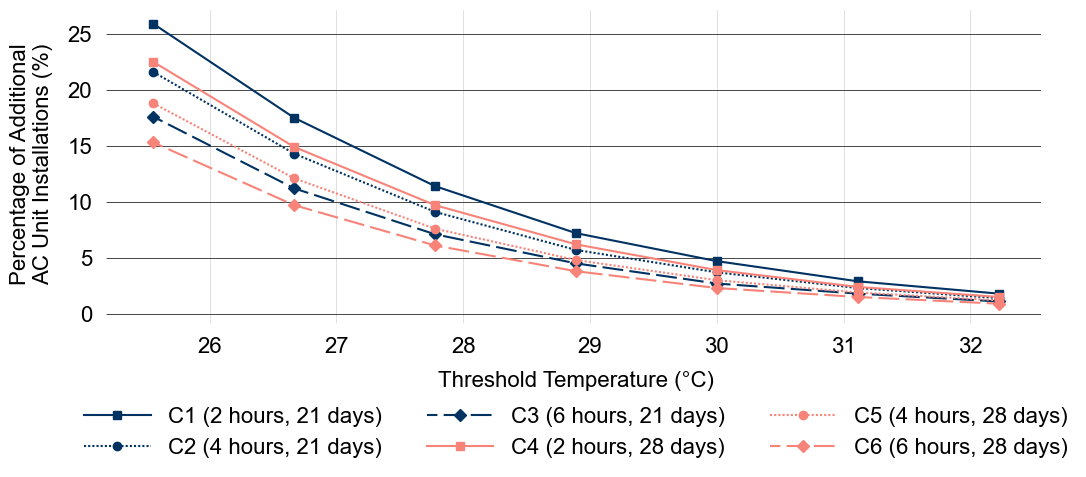

In [92]:

# ----------------------------------------------------------------------------------------------------------------------------- #
# Plot percentage of additional AC units installed vs exceedance temperature
# ----------------------------------------------------------------------------------------------------------------------------- #

# Convert the threshold temperature from Fahrenheit to Celsius for plotting
sensitivity_results_df['threshold_temp_C'] = (sensitivity_results_df['threshold_temp'] - 32) * 5 / 9

# Setup figure
plt.figure(figsize = (12, 4))

# Define conditions
conditions = [
    (2, 21), (4, 21), (6, 21),
    (2, 28), (4, 28), (6, 28)
]

# Define line styles for different conditions
line_styles = [
    'solid',                    # solid
    (0, (1, 1)),                # dotted
    (5, (10, 3)),               # long dash with offset
    'solid',                    # solid
    (0, (1, 1)),                # dotted
    (5, (10, 3)),               # long dash with offset
]

# Define markers for different conditions
markers = ['s', 'o', 'D', 's', 'o', 'D']

# Define colors for the two groups of conditions
colors = ['#003262', '#003262', '#003262', '#F88379', '#F88379', '#F88379']

# Plot each condition
for (hour, day), line_style, marker, color in zip(conditions, line_styles, markers, colors):
    label = f'C{conditions.index((hour, day)) + 1} ({hour} hours, {day} days)'
    condition_df = sensitivity_results_df[(sensitivity_results_df['threshold_hour'] == hour) & (sensitivity_results_df['threshold_day'] == day)]
    plt.plot(condition_df['threshold_temp_C'], condition_df['percentage'], label = label, linestyle = line_style, marker = marker, color = color)

'''for (hour, day), line_style, marker, color in zip(conditions, line_styles, markers, colors):
    label = f'C{conditions.index((hour, day)) + 1} ({hour} hours, {day} days)'
    condition_df = sensitivity_results_df[(sensitivity_results_df['threshold_hour'] == hour) & (sensitivity_results_df['threshold_day'] == day)]
    plt.plot(condition_df['threshold_temp_C'], condition_df['added_peak_load'], label = label, linestyle = line_style, marker = marker, color = color)'''

# Add labels
# plt.title('Additional AC Unit Installations vs Threshold Temperature', fontsize = 20, pad = 10)
plt.xlabel('Threshold Temperature (°C)', fontsize = 16, labelpad = 10)
plt.ylabel('Percentage of Additional\nAC Unit Installations (%)', fontsize = 16, labelpad = 10)
# plt.ylabel('Added Cooling Peak Load (MW)', fontsize = 16, labelpad = 10)
plt.tick_params(axis = 'x', which = 'both', bottom = True, top = False, labelbottom = True, color = '#D3d3d3', width = 0.5, pad = 10)
plt.tick_params(axis = 'y', which = 'both', left = True, right = False, labelleft = True, color = 'black', width = 0.5, pad = 10)
plt.legend()
plt.grid(True)

# Remove the border lines and add custom grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.grid(axis = 'x', color = '#D3d3d3', linestyle = '-', linewidth = 0.5)
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.5)

# Add legend at the bottom in a single line
plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.225), ncol = 3, fontsize = 16, frameon = False, handlelength = 3)

# Adjust plot
plt.tight_layout

# Save the plot with high DPI
plot_name = "sensitivity-analysis.png"
save_path = os.path.join(figure_directory, plot_name)
plt.savefig(save_path, dpi = 600, bbox_inches = 'tight', format = 'png')

# Print plot
plt.show()

###### CA cooling peak load = total dwelling units in CA / total dwelling units in ResStock * peak load from ResStock simulation
###### CA cooling peak load =  14.3 million / 52, 218 *  peak load from ResStock simulation = 3876 MW
###### An estimate of cooling peak load from 2002-2012 Electricity Outlook Report  CEC was 7500 MW
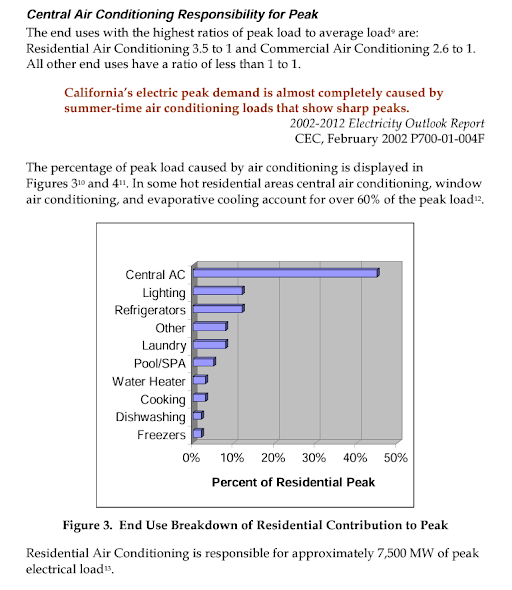

##### Statistics of AC electricy use (KWh) for homes with ACs

In [83]:
cooling_energy_df.sum(axis = 0).describe()

count    32533.000000
mean       215.991820
std        317.069779
min          0.000000
25%         17.508104
50%         93.097840
75%        299.291406
max       9671.026155
dtype: float64

##### Statistics of AC electricy use (KWh) for all homes (with and without ACs)

In [84]:
noAC_cooling_df = pd.Series([0] * sum(building_ids_without_ac))
new_cooling_df = pd.concat([noAC_cooling_df, cooling_energy_df.sum(axis = 0)], ignore_index=True)
new_cooling_df.describe()

count    52132.000000
mean       134.789800
std        271.445223
min          0.000000
25%          0.000000
50%         12.700544
75%        148.238678
max       9671.026155
dtype: float64

##### Add ACs to no-AC homes that don't meet the threshold

In [85]:
threshold_temperature = 28
threshold_hour = 1
threshold_day = 1

# 8 hour running mean
n_roll = 8
running_mean_df = indoor_temperature_df.rolling(n_roll).mean()
running_mean_df.iloc[:n_roll, :] = indoor_temperature_df.iloc[:n_roll, :]

# Group by date and check if any hourly value exceeds the threshold temperature
running_mean_df['Date'] = [pd.Timestamp(time_str).strftime('%Y/%m/%d') for time_str in timeseries]
overheat = running_mean_df.groupby(running_mean_df['Date']).apply(lambda x: (x > threshold_temperature).sum() > threshold_hour).sum() > threshold_day
overheat_df = pd.DataFrame({'Building': overheat.index, 'Overheating': overheat})

# df merge for map plot
merged_df = metadata.merge(overheat_df, how ='left', on ='Building')

cond_AC = merged_df['HVAC Cooling Type'].isnull()

# Baseline cooling energy use
cooling_energy_peak = max(cooling_energy_df.sum(axis = 1))
cooling_energy_total = cooling_energy_df.sum().sum()

# no-AC buildings that don't meet the requirement
cond_overheat = merged_df['Overheating'] == True
col_overheat = merged_df.loc[cond_overheat & cond_AC, 'Building'].values.tolist()

# pick buidling IDs from the all-AC df based on overheating results
noAC_cols = [col for col in cooling_energy_all_AC_df.columns if col in col_overheat]
print(f'{round(len(noAC_cols) / sum(cond_AC) * 100, 1)}% no-AC buildings need to add ACs')
print(f'{(len(noAC_cols) / sum(cond_AC)) * sum(building_ids_without_ac)} buildings in the sample would need to add ACs')
print(f'{round((len(noAC_cols) / sum(cond_AC)) * sum(building_ids_without_ac) * 14392140 / 52218, 0 )} buildings in the sample would need to add ACs (after scaling)')

# form new cooling df
cooling_df_new = cooling_energy_df.join(cooling_energy_all_AC_df[noAC_cols])  

# added peak load
allAC_cooling_peak = max(cooling_df_new.sum(axis = 1))
added_cooling_peak = allAC_cooling_peak - cooling_energy_peak
print(f'The added cooling peak load is estimated to be {round(added_cooling_peak / 1000 * 14392140 / 52218)} MW (+{round(added_cooling_peak / cooling_energy_peak * 100)}%) for CA')

# added total energy use 
allAC_cooling_tot = cooling_df_new.sum().sum()
added_cooling_tot = allAC_cooling_tot - cooling_energy_total
print(f'The added cooling total energy is estimated to be {round(added_cooling_tot / 1000 * 14392140 / 52218)} MWh (+{round(added_cooling_tot / cooling_energy_total * 100)}%) for CA')

29.7% no-AC buildings need to add ACs
5816.0 buildings in the sample would need to add ACs
1602985.0 buildings in the sample would need to add ACs (after scaling)
The added cooling peak load is estimated to be 892 MW (+23%) for CA
The added cooling total energy is estimated to be 499099 MWh (+26%) for CA


In [86]:
def calculate_AC_retrofit(metadata,
                          timeseries,
                          temperature_df,
                          cooling_energy_df,
                          cooling_energy_AC_df,
                          threshold_temperature,
                          threshold_hour,
                          threshold_day):
            
    # 8 hour running mean
    n_roll = 8
    running_mean_df = temperature_df.rolling(n_roll).mean()
    running_mean_df.iloc[:n_roll, :] = temperature_df.iloc[:n_roll, :]

    # Group by date and check if any hourly value exceeds the threshold temperature
    running_mean_df['Date'] = [pd.Timestamp(time_str).strftime('%Y/%m/%d') for time_str in timeseries]
    overheat = running_mean_df.groupby(running_mean_df['Date']).apply(lambda x: (x > threshold_temperature).sum() > threshold_hour).sum() > threshold_day
    overheat_df = pd.DataFrame({'Building': overheat.index, 'Overheating': overheat})
    
    # df merge for map plot
    merged_df = metadata.merge(overheat_df, how ='left', on ='Building')
    
    cond_AC = merged_df['HVAC Cooling Type'].isnull()

    # Baseline cooling energy use
    cooling_energy_peak = max(cooling_energy_df.sum(axis = 1))
    cooling_energy_total = cooling_energy_df.sum().sum()

    # no-AC buildings that don't meet the requirement
    cond_overheat = merged_df['Overheating'] == True
    col_overheat = merged_df.loc[cond_overheat & cond_AC, 'Building'].values.tolist()

    # pick buidling IDs from the all-AC df based on overheating results
    noAC_cols = [col for col in cooling_energy_AC_df.columns if col in col_overheat]
    print(f'{round(len(noAC_cols)/ sum(cond_AC) * 100, 1)}% no-AC buildings need to add ACs')
    
    # form new cooling df
    cooling_df_new = cooling_energy_df.join(cooling_energy_AC_df[noAC_cols])  
    
    # added peak load
    allAC_cooling_peak = max(cooling_df_new.sum(axis = 1))
    added_cooling_peak = allAC_cooling_peak - cooling_energy_peak
    print(f'Added cooling peak load is estimated to be {round(added_cooling_peak/1000 * (14.3) * 10**6 / 52218)} MW (+{round(added_cooling_peak/cooling_energy_peak * 100)}%) for CA')

    # added total energy use 
    allAC_cooling_tot = cooling_df_new.sum().sum()
    added_cooling_tot = allAC_cooling_tot - cooling_energy_total
    print(f'Added cooling total energy is estimated to be {round(added_cooling_tot/1000 * (14.3) * 10**6 / 52218)} MWh (+{round(added_cooling_tot/cooling_energy_total * 100)}%) for CA')

In [87]:
calculate_AC_retrofit(metadata = metadata,
                      timeseries = timeseries,
                      temperature_df = indoor_temperature_df,
                      cooling_energy_df = cooling_energy_df,
                      cooling_energy_AC_df = cooling_energy_all_AC_df,
                      threshold_temperature = 28,
                      threshold_hour = 1,
                      threshold_day = 1)

29.7% no-AC buildings need to add ACs
Added cooling peak load is estimated to be 886 MW (+23%) for CA
Added cooling total energy is estimated to be 495903 MWh (+26%) for CA


### Indoor Dry Bulb Air Temperature

In [93]:
indoor_temperature_df.median().describe()

count    52153.000000
mean        19.263210
std          2.365734
min          7.538562
25%         17.953089
50%         18.945292
75%         20.373277
max         40.381855
dtype: float64

In [94]:
# ----------------------------------------------------------------------------------------------------------------------------- #
# Initialize an empty dictionary to store filtered building identifiers for each county
# ----------------------------------------------------------------------------------------------------------------------------- #
temp_building_ids_by_county = {}

# Loop through each key-value pair in the 'building_ids_by_county' dictionary
for key, value in building_ids_by_county.items():
    # Create a list of building identifiers that are present in both 'indoor_temperature_df' columns and the current 'value' list
    temp_building_ids_by_county[key] = list(set(indoor_temperature_df.columns.to_list()) & set(value))

# ----------------------------------------------------------------------------------------------------------------------------- #
# Initialize an empty dictionary to store filtered building identifiers (without AC) for each county
# ----------------------------------------------------------------------------------------------------------------------------- #
temp_noACbuilding_ids_by_county = {}

# Loop through each key-value pair in the 'building_ids_without_ac_by_county' dictionary
for key, value in building_ids_without_ac_by_county.items():
    # Create a list of building identifiers (without AC) that are present in both 'indoor_temperature_df' columns and the current 'value' list
    temp_noACbuilding_ids_by_county[key] = list(set(indoor_temperature_df.columns.to_list()) & set(value))
    
# ----------------------------------------------------------------------------------------------------------------------------- #
# Initialize an empty dictionary to store filtered building identifiers for each county
# ----------------------------------------------------------------------------------------------------------------------------- #
temp_ACbuilding_ids_by_county = {}

# Loop through each key-value pair in the 'building_ids_by_county' dictionary
for key, value in building_ids_by_county.items():
    # Exclude buildings without AC
    buildings_with_AC = set(value) - set(building_ids_without_ac_by_county.get(key, []))
    # Create a list of building identifiers that are present in both 'indoor_temperature_df' columns and the filtered 'buildings_with_AC' list
    temp_ACbuilding_ids_by_county[key] = list(set(indoor_temperature_df.columns.to_list()) & buildings_with_AC)

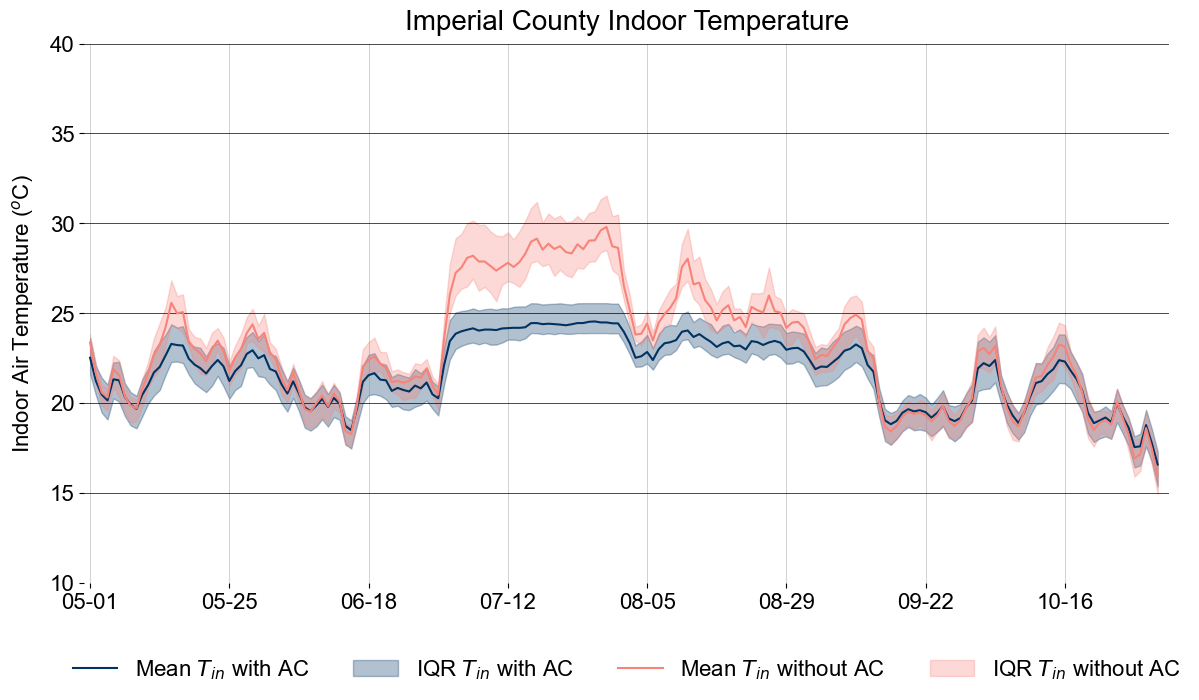

In [96]:
# Specify the county name
county_name = 'Imperial'

'''
# Separate data for buildings, either with or without AC, at specified county
combined_building_ids = temp_ACbuilding_ids_by_county[county_name] + temp_noACbuilding_ids_by_county[county_name]
combined_building_ids = [bid for bid in combined_building_ids if bid in outdoor_temperature_df.columns]             # Filter only those building IDs that exist in the DataFrame columns
outdoor_temperature_at_county = outdoor_temperature_df[combined_building_ids]
'''

# Separate data for buildings with and without AC at specified county
indoor_temperature_with_AC = indoor_temperature_df[temp_ACbuilding_ids_by_county[county_name]]
indoor_temperature_without_AC = indoor_temperature_df[temp_noACbuilding_ids_by_county[county_name]]

# Convert the index to datetime
indoor_temperature_with_AC.index = pd.to_datetime(indoor_temperature_with_AC.index)
indoor_temperature_without_AC.index = pd.to_datetime(indoor_temperature_without_AC.index)

# Aggregate to daily averages
# outdoor_temperature_daily = outdoor_temperature_at_county.resample('D').mean()
indoor_temperature_with_AC_daily = indoor_temperature_with_AC.resample('D').mean()
indoor_temperature_without_AC_daily = indoor_temperature_without_AC.resample('D').mean()

'''
# Calculate the required statistics on the daily average outdoor data for all buildings
outdoor_temperature_statistics = outdoor_temperature_daily.agg(['mean', 'std'], axis = 1)
outdoor_temperature_statistics['CI_lower'] = outdoor_temperature_daily.quantile(0.25, axis = 1)
outdoor_temperature_statistics['CI_upper'] = outdoor_temperature_daily.quantile(0.75, axis = 1)
'''

# Calculate the required statistics on the daily average indoor data for buildings with AC
indoor_temperature_with_AC_statistics = indoor_temperature_with_AC_daily.agg(['mean', 'std'], axis = 1)
indoor_temperature_with_AC_statistics['CI_lower'] = indoor_temperature_with_AC_daily.quantile(0.25, axis = 1)
indoor_temperature_with_AC_statistics['CI_upper'] = indoor_temperature_with_AC_daily.quantile(0.75, axis = 1)

# Calculate the required statistics on the daily average indoor data for buildings without AC
indoor_temperature_without_AC_statistics = indoor_temperature_without_AC_daily.agg(['mean', 'std'], axis = 1)
indoor_temperature_without_AC_statistics['CI_lower'] = indoor_temperature_without_AC_daily.quantile(0.25, axis = 1)
indoor_temperature_without_AC_statistics['CI_upper'] = indoor_temperature_without_AC_daily.quantile(0.75, axis = 1)

# Generate tick labels for the x-axis
timeseries_tick_label = [x.strftime('%m-%d') for x in indoor_temperature_with_AC_statistics.index]

# Reset the index for plotting
# outdoor_temperature_statistics.reset_index(inplace = True)
indoor_temperature_with_AC_statistics.reset_index(inplace = True)
indoor_temperature_without_AC_statistics.reset_index(inplace = True)

# Setup figure
plt.figure(figsize = (14, 7))

# Plot the outdoor temperature for buildings
# plt.plot(outdoor_temperature_statistics['mean'], label = 'Mean $T_{out}$')

# Plot the mean indoor temperature for buildings with AC
plt.plot(indoor_temperature_with_AC_statistics['mean'],
         color = '#003262',
         label = 'Mean $T_{in}$ with AC')

# Add confidence intervals for buildings with AC
plt.fill_between(indoor_temperature_with_AC_statistics.index, 
                 indoor_temperature_with_AC_statistics['CI_lower'], 
                 indoor_temperature_with_AC_statistics['CI_upper'], 
                 color = '#003262',
                 alpha = 0.3, 
                 label = 'IQR $T_{in}$ with AC')

# Plot the mean indoor temperature for buildings without AC
plt.plot(indoor_temperature_without_AC_statistics['mean'], 
         color = '#F88379', 
         label = 'Mean $T_{in}$ without AC')

# Add confidence intervals for buildings without AC
plt.fill_between(indoor_temperature_without_AC_statistics.index, 
                 indoor_temperature_without_AC_statistics['CI_lower'], 
                 indoor_temperature_without_AC_statistics['CI_upper'], 
                 color = '#F88379', 
                 alpha = 0.3, 
                 label = 'IQR $T_{in}$ without AC')

# Plot settings
plt.title(f'{county_name} County Indoor Temperature', fontsize = 20, pad = 10)
plt.xlim([-1, len(indoor_temperature_with_AC_statistics) + 1])
plt.ylim(10, 40)
plt.xticks(indoor_temperature_with_AC_statistics.index[::24], timeseries_tick_label[::24], fontsize = 16, rotation = 0)
plt.yticks(fontsize = 16)
plt.ylabel('Indoor Air Temperature ($^o$C)', fontsize = 16, labelpad = 10)
plt.legend(fontsize = 16, frameon = False)

# Remove the border lines and add custom grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.5)
plt.grid(axis = 'x', color = 'gray', linestyle = '-', linewidth = 0.5, alpha = 0.5)

# Add legend at the bottom in a single line
plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.1), ncol = 4, fontsize = 16, frameon = False)

# Save the plot with high DPI
plot_name = "indoor_temperature_timeseries.png"
save_path = os.path.join(figure_directory, plot_name)
plt.savefig(save_path, dpi = 600, bbox_inches = 'tight', format = 'png')

# Show the plot
plt.show()

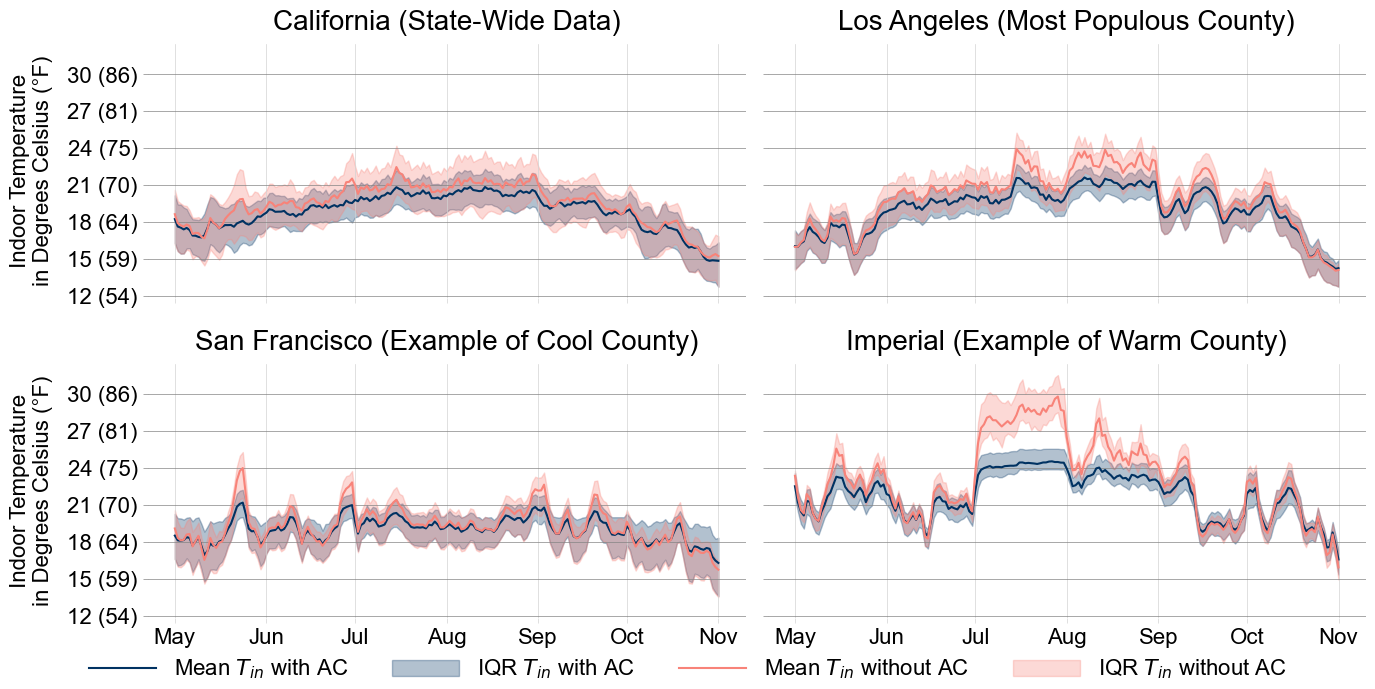

In [97]:
# Define counties and their specific color for plotting
counties = ['California', 'Los Angeles', 'San Francisco', 'Imperial']
color_with_AC = '#003262'
color_without_AC = '#F88379'

# Combine all building columns for buildings with and without AC across all counties
columns_with_AC = [col for cols in temp_ACbuilding_ids_by_county.values() for col in cols]
columns_without_AC = [col for cols in temp_noACbuilding_ids_by_county.values() for col in cols]

# Create a 2x2 subplot structure
fig, axes = plt.subplots(2, 2, figsize = (14, 7), sharex = True, sharey = True)
axes = axes.flatten()

# Define the font properties
font = {'fontname': 'Times New Roman'}

for i, county in enumerate(counties):
    
    if county == 'California':
        # Use combined data for California
        indoor_temperature_with_AC = indoor_temperature_df[columns_with_AC]
        indoor_temperature_without_AC = indoor_temperature_df[columns_without_AC]
        
    else:
        # Use specific county data
        indoor_temperature_with_AC = indoor_temperature_df[temp_ACbuilding_ids_by_county[county]]
        indoor_temperature_without_AC = indoor_temperature_df[temp_noACbuilding_ids_by_county[county]]
    
    # Convert the index to datetime
    indoor_temperature_with_AC.index = pd.to_datetime(indoor_temperature_with_AC.index)
    indoor_temperature_without_AC.index = pd.to_datetime(indoor_temperature_without_AC.index)
    
    # Aggregate to daily averages
    indoor_temperature_with_AC_daily = indoor_temperature_with_AC.resample('D').mean()
    indoor_temperature_without_AC_daily = indoor_temperature_without_AC.resample('D').mean()

    # Calculate the required statistics on the daily average indoor data for buildings with AC
    indoor_temperature_with_AC_statistics = indoor_temperature_with_AC_daily.agg(['mean', 'std'], axis = 1)
    indoor_temperature_with_AC_statistics['CI_lower'] = indoor_temperature_with_AC_daily.quantile(0.25, axis = 1)
    indoor_temperature_with_AC_statistics['CI_upper'] = indoor_temperature_with_AC_daily.quantile(0.75, axis = 1)

    # Calculate the required statistics on the daily average indoor data for buildings without AC
    indoor_temperature_without_AC_statistics = indoor_temperature_without_AC_daily.agg(['mean', 'std'], axis = 1)
    indoor_temperature_without_AC_statistics['CI_lower'] = indoor_temperature_without_AC_daily.quantile(0.25, axis = 1)
    indoor_temperature_without_AC_statistics['CI_upper'] = indoor_temperature_without_AC_daily.quantile(0.75, axis = 1)

    # Plot each county's data in its subplot
    ax = axes[i]
    
    # Plot the mean indoor temperature for buildings with AC
    ax.plot(indoor_temperature_with_AC_statistics['mean'],
            color = color_with_AC,
            label = 'Mean $T_{in}$ with AC')

    # Add confidence intervals for buildings with AC
    ax.fill_between(indoor_temperature_with_AC_statistics.index, 
                    indoor_temperature_with_AC_statistics['CI_lower'], 
                    indoor_temperature_with_AC_statistics['CI_upper'], 
                    color = color_with_AC,
                    alpha = 0.3, 
                    label = 'IQR $T_{in}$ with AC')
    
    # Plot the mean indoor temperature for buildings without AC
    ax.plot(indoor_temperature_without_AC_statistics['mean'], 
             color = color_without_AC,
             label = 'Mean $T_{in}$ without AC')

    # Add confidence intervals for buildings without AC
    ax.fill_between(indoor_temperature_without_AC_statistics.index, 
                        indoor_temperature_without_AC_statistics['CI_lower'], 
                        indoor_temperature_without_AC_statistics['CI_upper'], 
                        color = color_without_AC, 
                        alpha = 0.3, 
                        label = 'IQR $T_{in}$ without AC')
    
     # Custom titles for each county
    if county == 'Los Angeles':
        ax.set_title('Los Angeles (Most Populous County)', fontsize = 20, pad = 10)
    elif county == 'San Francisco':
        ax.set_title('San Francisco (Example of Cool County)', fontsize = 20, pad = 10)
    elif county == 'Imperial':
        ax.set_title('Imperial (Example of Warm County)', fontsize = 20, pad = 10)
    else:
        ax.set_title('California (State-Wide Data)', fontsize = 20, pad = 10)
    
    # Enable grid lines  
    ax.grid(True)
    
    # Adjust axis labels and tick marks based on their position
    if i == 0:
        ax.tick_params(axis = 'x', which = 'both', bottom = True, top = False, labelbottom = False, color = '#D3d3d3', width = 0.5)
        ax.tick_params(axis = 'y', which = 'both', left = True, right = False, labelleft = True, color = '#848484', width = 0.5)
        ax.set_ylabel('Indoor Temperature\nin Degrees Celsius (°F)', fontsize = 16, labelpad = 10)
    
    elif i == 1:
        ax.tick_params(axis = 'x', which = 'both', bottom = True, top = False, labelbottom = False, color = '#D3d3d3', width = 0.5)
        ax.tick_params(axis = 'y', which = 'both', left = True, right = False, labelleft = False, color = '#848484', width = 0.5)
        ax.set_ylabel('', fontsize = 16, labelpad = 10)
    
    elif i == 2:
        ax.tick_params(axis = 'x', which = 'both', bottom = True, top = False, labelbottom = True, color = '#D3d3d3', width = 0.5)
        ax.tick_params(axis = 'y', which = 'both', left = True, right = False, labelleft = True, color = '#848484', width = 0.5)
        ax.set_ylabel('Indoor Temperature\nin Degrees Celsius (°F)', fontsize = 16, labelpad = 10)
                
    else:
        ax.tick_params(axis = 'x', which = 'both', bottom = True, top = False, labelbottom = True, color = '#D3d3d3', width = 0.5)
        ax.tick_params(axis = 'y', which = 'both', left = True, right = False, labelleft = False, color = '#848484', width = 0.5)
        ax.set_ylabel('', fontsize = 16, labelpad = 10)
    
    # Use DateFormatter to format the x-axis labels to abbreviated month names
    ax.xaxis.set_major_formatter(DateFormatter('%b'))
    
    # Function to convert Celsius to Fahrenheit and format the string
    def celsius_to_fahrenheit(x, pos):
        """Converts Celsius to Fahrenheit and formats the string for y-axis labels"""
        fahrenheit = x * 9/5 + 32
        return f"{x:.0f} ({fahrenheit:.0f})"

    # Create the formatter
    formatter = FuncFormatter(celsius_to_fahrenheit)

    # Applying the formatter to the y-axis of your plot
    ax.yaxis.set_major_formatter(formatter)
    
    # Remove the border lines and add custom grid lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(axis = 'x', color = '#D3d3d3', linestyle = '-', linewidth = 0.5)
    ax.grid(axis = 'y', color = '#848484', linestyle = '-', linewidth = 0.5)

# Adjust layout
plt.tight_layout(pad = 1, h_pad = 1.5, w_pad = 1)

# Use MaxNLocator to display x-axis labels as integers
for ax in axes:
    ax.yaxis.set_major_locator(MaxNLocator(integer = True))

# Create a custom legend for the entire figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:4], labels[:4], loc = 'lower center', bbox_to_anchor = (0.5, 0.025), ncol = 4, fontsize = 16, borderpad = -1, frameon = False, handlelength = 3)
plt.subplots_adjust(bottom = 0.1)

# Save the plot with high DPI
plot_name = "indoor-temperature-timeseries.png"
save_path = os.path.join(figure_directory, plot_name)
plt.savefig(save_path, dpi = 600, bbox_inches = 'tight', format = 'png')

# Show the plot
plt.show()

In [ ]:
# Convert the table index to datetime format
indoor_temperature_df.index = pd.to_datetime(indoor_temperature_df.index, format = '%Y/%m/%d %H:%M:%S')

# Directory to save the plots
output_dir = 'D:/py/results'
os.makedirs(output_dir, exist_ok = True)

# Iterate over each county
for county_name in temp_ACbuilding_ids_by_county.keys():
    # Separate data for buildings with and without AC
    indoor_temperature_with_AC = indoor_temperature_df[temp_ACbuilding_ids_by_county[county_name]]
    indoor_temperature_without_AC = indoor_temperature_df[temp_noACbuilding_ids_by_county[county_name]]

    # Aggregate to daily averages
    indoor_temperature_with_AC_daily = indoor_temperature_with_AC.resample('D').mean()
    indoor_temperature_without_AC_daily = indoor_temperature_without_AC.resample('D').mean()

    # Calculate the required statistics on the daily average data for buildings with AC
    indoor_temperature_with_AC_statistics = indoor_temperature_with_AC_daily.agg(['mean', 'std'], axis = 1)
    indoor_temperature_with_AC_statistics['CI_lower'] = indoor_temperature_with_AC_daily.quantile(0.25, axis = 1)
    indoor_temperature_with_AC_statistics['CI_upper'] = indoor_temperature_with_AC_daily.quantile(0.75, axis = 1)

    # Calculate the required statistics on the daily average data for buildings without AC
    indoor_temperature_without_AC_statistics = indoor_temperature_without_AC_daily.agg(['mean', 'std'], axis = 1)
    indoor_temperature_without_AC_statistics['CI_lower'] = indoor_temperature_without_AC_daily.quantile(0.25, axis = 1)
    indoor_temperature_without_AC_statistics['CI_upper'] = indoor_temperature_without_AC_daily.quantile(0.75, axis = 1)

    # Generate tick labels for the x-axis
    timeseries_tick_label = [x.strftime('%m-%d') for x in indoor_temperature_with_AC_statistics.index]

    # Reset the index for plotting
    indoor_temperature_with_AC_statistics.reset_index(inplace = True)
    indoor_temperature_without_AC_statistics.reset_index(inplace = True)

    plt.figure(figsize = (18, 9))

    # Plot the mean indoor temperature for buildings with AC
    plt.plot(indoor_temperature_with_AC_statistics['mean'], label = 'Mean $T_{in}$ with AC')

    # Add confidence intervals for buildings with AC
    plt.fill_between(indoor_temperature_with_AC_statistics.index, 
                     indoor_temperature_with_AC_statistics['CI_lower'], 
                     indoor_temperature_with_AC_statistics['CI_upper'], 
                     alpha = 0.3, 
                     label = 'Variation (Q1 - Q3) with AC')

    # Plot the mean indoor temperature for buildings without AC
    plt.plot(indoor_temperature_without_AC_statistics['mean'], 
             label = 'Mean $T_{in}$ without AC')

    # Add confidence intervals for buildings without AC
    plt.fill_between(indoor_temperature_without_AC_statistics.index, 
                     indoor_temperature_without_AC_statistics['CI_lower'], 
                     indoor_temperature_without_AC_statistics['CI_upper'], 
                     alpha = 0.3, 
                     label = 'Variation (Q1 - Q3) without AC')

    # Plot settings
    plt.title(f'{county_name} County Indoor Temperature', fontsize = 16)
    plt.xlim([-1, len(indoor_temperature_with_AC_statistics) + 1])
    plt.ylim(10, 40)
    plt.xlabel('Time', fontsize = 14)
    plt.xticks(indoor_temperature_with_AC_statistics.index[::24], timeseries_tick_label[::24], fontsize = 12, rotation = 0)
    plt.yticks(fontsize = 14)
    plt.ylabel('Indoor Air Temperature ($^o$C)', fontsize = 16)
    plt.legend(fontsize = 14, frameon = False)

    # Remove the border lines and add custom grid lines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.5)
    plt.grid(axis = 'x', color = 'gray', linestyle = '-', linewidth = 0.5, alpha = 0.5)

    # Save the plot as PNG file
    plt.savefig(os.path.join(output_dir, f'{county_name}_indoor_temperature.png'))
    plt.show()

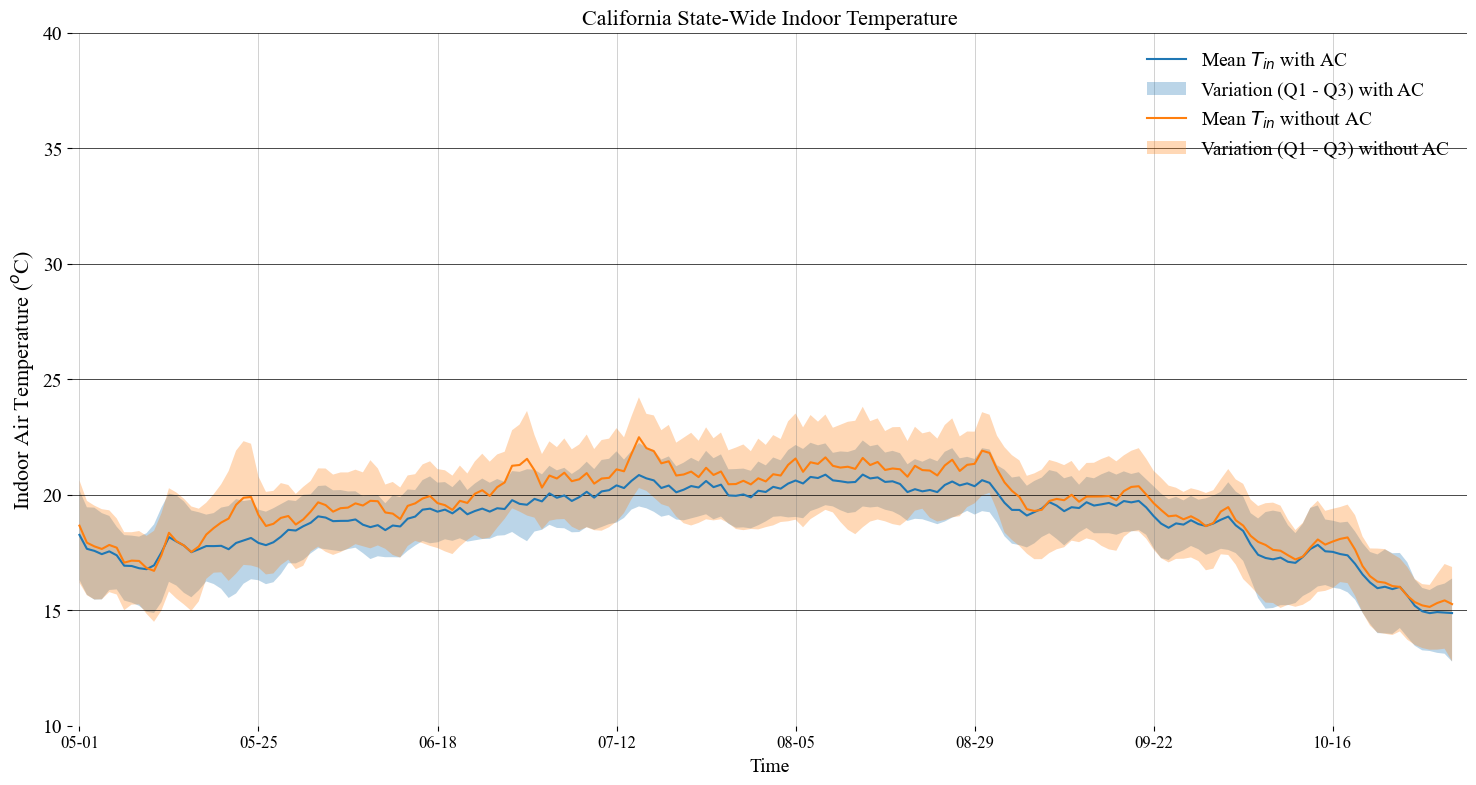

In [40]:
# Convert the table index to datetime format
indoor_temperature_df.index = pd.to_datetime(indoor_temperature_df.index, format='%Y/%m/%d %H:%M:%S')

# Combine all building columns for buildings with and without AC across all counties
columns_with_AC = [col for cols in temp_ACbuilding_ids_by_county.values() for col in cols]
columns_without_AC = [col for cols in temp_noACbuilding_ids_by_county.values() for col in cols]

# Separate data for buildings with and without AC
indoor_temperature_with_AC = indoor_temperature_df[columns_with_AC]
indoor_temperature_without_AC = indoor_temperature_df[columns_without_AC]

# Aggregate to daily averages
indoor_temperature_with_AC_daily = indoor_temperature_with_AC.resample('D').mean()
indoor_temperature_without_AC_daily = indoor_temperature_without_AC.resample('D').mean()

# Calculate the required statistics on the daily average data for buildings with AC
indoor_temperature_with_AC_statistics = indoor_temperature_with_AC_daily.agg(['mean', 'std'], axis=1)
indoor_temperature_with_AC_statistics['CI_lower'] = indoor_temperature_with_AC_daily.quantile(0.25, axis=1)
indoor_temperature_with_AC_statistics['CI_upper'] = indoor_temperature_with_AC_daily.quantile(0.75, axis=1)

# Calculate the required statistics on the daily average data for buildings without AC
indoor_temperature_without_AC_statistics = indoor_temperature_without_AC_daily.agg(['mean', 'std'], axis=1)
indoor_temperature_without_AC_statistics['CI_lower'] = indoor_temperature_without_AC_daily.quantile(0.25, axis=1)
indoor_temperature_without_AC_statistics['CI_upper'] = indoor_temperature_without_AC_daily.quantile(0.75, axis=1)

# Generate tick labels for the x-axis
timeseries_tick_label = [x.strftime('%m-%d') for x in indoor_temperature_with_AC_statistics.index]

# Reset the index for plotting
indoor_temperature_with_AC_statistics.reset_index(inplace = True)
indoor_temperature_without_AC_statistics.reset_index(inplace = True)

plt.figure(figsize = (18, 9))

# Plot the mean indoor temperature for buildings with AC
plt.plot(indoor_temperature_with_AC_statistics['mean'], label = 'Mean $T_{in}$ with AC')

# Add confidence intervals for buildings with AC
plt.fill_between(indoor_temperature_with_AC_statistics.index, 
                 indoor_temperature_with_AC_statistics['CI_lower'], 
                 indoor_temperature_with_AC_statistics['CI_upper'], 
                 alpha = 0.3, 
                 label = 'Variation (Q1 - Q3) with AC')

# Plot the mean indoor temperature for buildings without AC
plt.plot(indoor_temperature_without_AC_statistics['mean'], 
         label = 'Mean $T_{in}$ without AC')

# Add confidence intervals for buildings without AC
plt.fill_between(indoor_temperature_without_AC_statistics.index, 
                 indoor_temperature_without_AC_statistics['CI_lower'], 
                 indoor_temperature_without_AC_statistics['CI_upper'], 
                 alpha = 0.3, 
                 label = 'Variation (Q1 - Q3) without AC')

# Plot settings
plt.title('California State-Wide Indoor Temperature', fontsize = 16)
plt.xlim([-1, len(indoor_temperature_with_AC_statistics) + 1])
plt.ylim(10, 40)
plt.xlabel('Time', fontsize = 14)
plt.xticks(indoor_temperature_with_AC_statistics.index[::24], timeseries_tick_label[::24], fontsize = 12, rotation = 0)
plt.yticks(fontsize = 14)
plt.ylabel('Indoor Air Temperature ($^o$C)', fontsize = 16)
plt.legend(fontsize = 14, frameon = False)

# Remove the border lines and add custom grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.5)
plt.grid(axis = 'x', color = 'gray', linestyle = '-', linewidth = 0.5, alpha = 0.5)

# Show the plot
plt.show()

#### AC Prevalence and Overheating Assessment

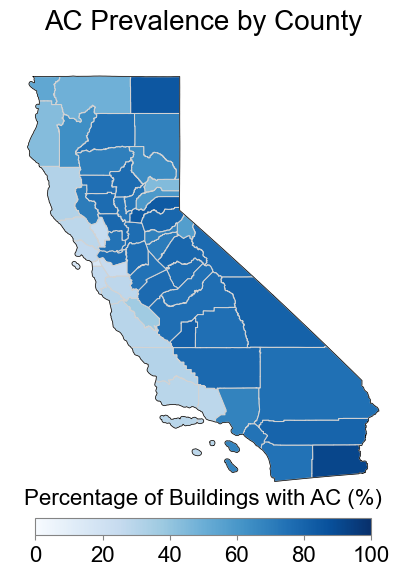

In [8]:
# Define file paths
main_folder = "D:/"
metadata_directory = os.path.join(main_folder, "py/california_baseline_50k_modified.csv")
county_shapefile_directory = r"map/ca-county-boundaries/CA_Counties/CA_Counties_TIGER2016.shp"
state_shapefile_directory = r"map/ca-state-boundary/CA_State_TIGER2016.shp"

# Read metadata
metadata = pd.read_csv(metadata_directory)

# Extract county names
metadata['County'] = metadata['County'].apply(lambda x: x.split('CA, ')[1].split(' County')[0])

# Count buildings with AC
with_AC = metadata[metadata['HVAC Cooling Type'].notnull()]
ac_count = with_AC['County'].value_counts().reset_index()
ac_count.columns = ['County', 'Count of Units with AC']

# Count all buildings
total_count = metadata['County'].value_counts().reset_index()
total_count.columns = ['County', 'Total']

# Calculate percentage of buildings with AC
ac_percentage = ac_count.merge(total_count, on = 'County')
ac_percentage['Value'] = ac_percentage['Count of Units with AC'] / ac_percentage['Total']

# Read the county and state shapefiles
california_counties = gpd.read_file(county_shapefile_directory)
california_state = gpd.read_file(state_shapefile_directory)

# Set minimum and maximum values for color scale
vmin = 0
vmax = 1

# Merge county data with AC data
california_counties = california_counties.merge(ac_percentage, 
                                                how = 'left', 
                                                left_on = 'NAME', 
                                                right_on = 'County')

# Plotting
fig, ax = plt.subplots(1, figsize = (9, 6))
plt.axis('off')

# Define color map
cmap = 'Blues'

# Plot the counties with data
california_counties.plot(column = 'Value', 
                         cmap = cmap, 
                         linewidth = 0.75, 
                         ax = ax, 
                         edgecolor = '#D3d3d3', 
                         vmin = vmin, 
                         vmax = vmax)

# Overlay the state outline
california_state.plot(ax = ax, 
                      color = 'none', 
                      edgecolor = 'black', 
                      linewidth = 0.5)

# Add color bar horizontally below map
sm = plt.cm.ScalarMappable(cmap = cmap, 
                           norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
cbar = fig.colorbar(sm, ax = ax, orientation = 'horizontal', fraction = 0.035, pad = 0.035)
cbar.set_label('Percentage of Buildings with AC (%)', fontsize = 16, labelpad = -55)
ticks = np.linspace(vmin, vmax, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{int(tick * 100)}' for tick in ticks])
cbar.ax.tick_params(labelsize = 16, color = '#848484')
cbar.outline.set_edgecolor('#848484')

# Add title
# title = '(a)'
title = 'AC Prevalence by County'
ax.set_title(title, fontsize = 20, pad = -10)

# Adjust layout
plt.tight_layout(pad = 1)

# Save the plot with high DPI
plot_name = "ac-prevalence-map-v2.png"
save_path = os.path.join(figure_directory, plot_name)
plt.savefig(save_path, dpi = 600, bbox_inches = 'tight', format = 'png')

# Show plot
plt.show()

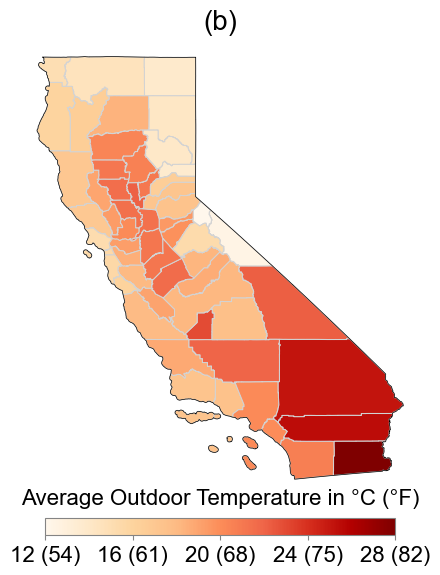

In [9]:
# Define file paths
main_folder = "D:/"
county_shapefile_directory = r"map/ca-county-boundaries/CA_Counties/CA_Counties_TIGER2016.shp"
state_shapefile_directory = r"map/ca-state-boundary/CA_State_TIGER2016.shp"

# Import the outdoor temperature DataFrame
outdoor_temperature_df = pd.read_csv(os.path.join(main_folder, "py/outdoor_temperatures.csv"), skiprows = 4)
outdoor_temperature_df['Name'] = outdoor_temperature_df['Name'].str.replace(' County', '')
outdoor_temperature_df = outdoor_temperature_df.rename(columns={'Name': 'County'})
outdoor_temperature_df['1901-2000 Mean (°C)'] = (outdoor_temperature_df['1901-2000 Mean'] - 32) * 5.0/9.0

# Read the county and state shapefiles
california_counties = gpd.read_file(county_shapefile_directory)
california_state = gpd.read_file(state_shapefile_directory)

# Function to round to the nearest even number
def round_to_even(value):
    return round(value / 2) * 2

# Set minimum and maximum values for color scale
vmin = round_to_even(math.floor(outdoor_temperature_df['1901-2000 Mean (°C)'].min()))
vmax = round_to_even(math.ceil(outdoor_temperature_df['1901-2000 Mean (°C)'].max()))

# Merge county data with outdoor temperature data
california_counties = california_counties.merge(outdoor_temperature_df,
                                                how = 'left',
                                                left_on = 'NAME',
                                                right_on = 'County')

# Plotting
fig, ax = plt.subplots(1, figsize = (9, 6))
plt.axis('off')

# Define color map
cmap = 'OrRd'

# Plot the counties with data
california_counties.plot(column = '1901-2000 Mean (°C)', 
                         cmap = cmap, 
                         linewidth = 0.75, 
                         ax = ax, 
                         edgecolor = '#D3d3d3', 
                         vmin = vmin, 
                         vmax = vmax)

# Overlay the state outline
california_state.plot(ax = ax, 
                      color = 'none', 
                      edgecolor = 'black', 
                      linewidth = 0.5)

# Function to convert Celsius to Fahrenheit
def celsius_to_fahrenheit(c):
    return (c * 9/5) + 32

# Set tickmark intervals
tick_interval = 4
ticks = np.arange(vmin, vmax + tick_interval, tick_interval)

# Color bar settings with adjusted ticks
sm = plt.cm.ScalarMappable(cmap = cmap, 
                           norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
cbar = fig.colorbar(sm, ax = ax, orientation = 'horizontal', fraction = 0.035, pad = 0.035)
cbar.set_label('Average Outdoor Temperature in °C (°F)', fontsize = 16, labelpad = -55)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])
cbar.ax.tick_params(labelsize = 16, color = '#848484')
cbar.outline.set_edgecolor('#848484')

# Set ticks and format labels to show both °C and °F
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{c:.0f} ({celsius_to_fahrenheit(c):.0f})' for c in ticks])

# Add title and subtitle
title = '(b)'
# title = 'Average Outdoor Temperature by County'
# subtitle = '6-Month Period Between May to October'
ax.set_title(title, fontsize = 20, pad = -10)
# ax.text(0.5, 0.99, subtitle, transform = ax.transAxes, fontsize = 16, va = 'bottom', ha = 'center')

# Adjust layout
plt.tight_layout(pad = 1)

# Save the plot with high DPI
plot_name = "outdoor-temperature-map-v2.png"
save_path = os.path.join(figure_directory, plot_name)
# plt.savefig(save_path, dpi = 600, bbox_inches = 'tight', format = 'png')

# Show plot
plt.show()

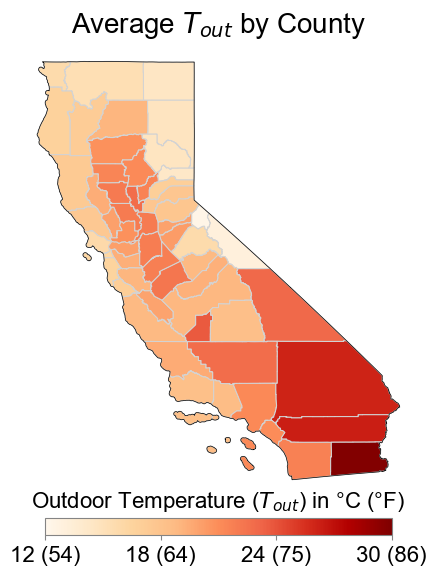

In [16]:
# Define file paths
main_folder = "D:/"
county_shapefile_directory = r"map/ca-county-boundaries/CA_Counties/CA_Counties_TIGER2016.shp"
state_shapefile_directory = r"map/ca-state-boundary/CA_State_TIGER2016.shp"

# Import the outdoor temperature DataFrame
outdoor_temperature_df = pd.read_excel(os.path.join(main_folder, "py/NOAA data/outdoor temperature (1975 - 2023).xlsx"))

# Read the county and state shapefiles
california_counties = gpd.read_file(county_shapefile_directory)
california_state = gpd.read_file(state_shapefile_directory)

# Function to round to the nearest even number
def round_to_even(value):
    return round(value / 2) * 2

# Set minimum and maximum values for color scale
vmin = round_to_even(math.floor(outdoor_temperature_df['Degrees Celsius'].min()))
vmax = round_to_even(math.ceil(outdoor_temperature_df['Degrees Celsius'].max()))

# Merge county data with outdoor temperature data
california_counties = california_counties.merge(outdoor_temperature_df,
                                                how = 'left',
                                                left_on = 'NAME',
                                                right_on = 'County')

# Plotting
fig, ax = plt.subplots(1, figsize = (9, 6))
plt.axis('off')

# Define color map
cmap = 'OrRd'

# Plot the counties with data
california_counties.plot(column = 'Degrees Celsius', 
                         cmap = cmap, 
                         linewidth = 0.75, 
                         ax = ax, 
                         edgecolor = '#D3d3d3', 
                         vmin = vmin, 
                         vmax = vmax)

# Overlay the state outline
california_state.plot(ax = ax, 
                      color = 'none', 
                      edgecolor = 'black', 
                      linewidth = 0.5)

# Function to convert Celsius to Fahrenheit
def celsius_to_fahrenheit(c):
    return (c * 9/5) + 32

# Set tickmark intervals
tick_interval = 6
ticks = np.arange(vmin, vmax + tick_interval, tick_interval)

# Color bar settings with adjusted ticks
sm = plt.cm.ScalarMappable(cmap = cmap, 
                           norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
cbar = fig.colorbar(sm, ax = ax, orientation = 'horizontal', fraction = 0.035, pad = 0.035)
cbar.set_label('Outdoor Temperature ($T_{out}$) in °C (°F)', fontsize = 16, labelpad = -55)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])
cbar.ax.tick_params(labelsize = 16, color = '#848484')
cbar.outline.set_edgecolor('#848484')

# Set ticks and format labels to show both °C and °F
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{c:.0f} ({celsius_to_fahrenheit(c):.0f})' for c in ticks])

# Add title and subtitle
# title = '(b)'
title = 'Average $T_{out}$ by County'
# subtitle = '6-Month Period Between May to October'
ax.set_title(title, fontsize = 20, pad = -10)
# ax.text(0.5, 0.99, subtitle, transform = ax.transAxes, fontsize = 16, va = 'bottom', ha = 'center')

# Adjust layout
plt.tight_layout(pad = 1)

# Save the plot with high DPI
plot_name = "outdoor-temperature-map-v2.png"
save_path = os.path.join(figure_directory, plot_name)
plt.savefig(save_path, dpi = 600, bbox_inches = 'tight', format = 'png')

# Show plot
plt.show()

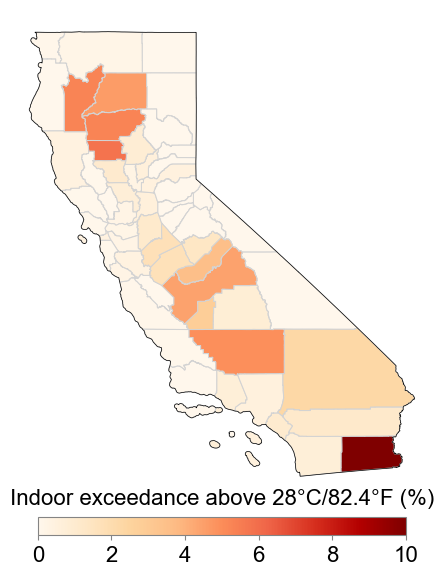

In [42]:
# Read the county and state shapefiles
california_counties = gpd.read_file(county_shapefile_directory)
california_state = gpd.read_file(state_shapefile_directory)

# Define the threshold temperature
threshold_temperature = 28

# Calculate the 8 hour running mean
n_roll = 8
runmean_df = indoor_temperature_df.rolling(n_roll).mean()
runmean_df.iloc[:n_roll, :] = indoor_temperature_df.iloc[:n_roll, :]

# Calculate exceedance hours based on threshold temperature
heatwave = None
degree_hours = None
exceedance_hours = (runmean_df > threshold_temperature).sum(axis = 0)

# Modify exceedance hours calculation based on timeframe and degree hours
if heatwave == 'Yes':
    exceedance_hours = exceedance_hours / 168
else:
    exceedance_hours = exceedance_hours / 4416
if degree_hours == 'Yes':
    cond = (runmean_df > threshold_temperature).astype(int)
    deg = runmean_df - threshold_temperature
    deg[deg < 0] = 0
    exceedance_hours = (cond * deg).sum(axis = 0)

# Create DataFrame for overheating hours
overheat_df = pd.DataFrame({'Building': exceedance_hours.index, 'Exceedance Hours': exceedance_hours}).reset_index(drop = True)

# Merge DataFrame for map plot
merged_df = metadata.merge(overheat_df, how ='left', on ='Building') 

# Filter DataFrame for buildings with or without AC
ac_type = 'No AC'
if ac_type == 'AC':
    cond_AC = merged_df['HVAC Cooling Type'].notnull()
    merged_df = merged_df.loc[cond_AC, :]
elif ac_type == 'No AC':
    cond_AC = merged_df['HVAC Cooling Type'].isnull()
    merged_df = merged_df.loc[cond_AC, :]

# Function to calculate mean excluding the top 5% of values within each group
def mean_exclude_top5_percent(group):
    
    # Determine the cutoff index for the top 5%
    cutoff_index = int(len(group) * 0.95)
    
    # Sort the values and exclude the top 5%
    sorted_group = group.sort_values().iloc[:cutoff_index]
    
    # Return the mean of the remaining values
    return sorted_group.mean()

# Calculate the average or median of exceedance hours for each county
metric = 'mean'
if metric == 'mean':
    overheat_pct = merged_df.groupby(merged_df['County'])['Exceedance Hours'].apply(mean_exclude_top5_percent)
elif metric == 'median':
    overheat_pct = merged_df.groupby(merged_df['County'])['Exceedance Hours'].median()

# Assigns exceedance hours for Tehama to Trinity
overheat_pct['Trinity'] = overheat_pct['Tehama']

# Convert series into a DataFrame
overheat_county = pd.DataFrame({'County': overheat_pct.index, 'Value': overheat_pct})
overheat_county.reset_index(drop = True, inplace = True)

# Plot
scal = 'low'
if heatwave == None:
    if max(overheat_pct) < 100:
        vmin = round(min(overheat_pct)/10) * 10
        vmax = round(max(overheat_pct)/10) * 10
    else:
        vmin = round(min(overheat_pct)/100) * 100
        vmax = round(max(overheat_pct)/100) * 100
    
    vmax = 0.1
    vmin = 0
    
    if scal == 'high':
        vmax = 0.2
        cmap_step = 0.05
else:
    vmin = 0
    if scal == 'high':
        vmax = 0.8
        cmap_step = 0.2
    elif scal == 'med':
        vmax = 0.6
        cmap_step = 0.15    
    else:
        vmax = 0.2
        cmap_step = 0.05    

# Clean the county names in DataFrame
overheat_county['County'] = overheat_county['County'].str.replace('CA, ', '').str.replace(' County', '')

# Merge the DataFrame with the California counties shapefile
california_counties = california_counties.merge(overheat_county, 
                                                how = 'left', 
                                                left_on = 'NAME', 
                                                right_on = 'County')

# Plot the map
fig, ax = plt.subplots(1, figsize = (9, 6)) 
plt.axis('off')

# tick_cbar = np.arange(vmin, vmax+1, 50)
tick_cbar = np.arange(0, vmax + 0.01, 0.02)
if scal == 'high':
    tick_cbar = np.arange(0, vmax + 0.01, 0.05)

# Calculate the aspect ratio
original_width, original_height = fig.get_figure().get_size_inches()
scal_fac = 1.2

# Define color map
cmap = 'OrRd'

# Plot the counties with data
california_counties.plot(column = 'Value', 
                         cmap = cmap, 
                         linewidth = 0.75, 
                         ax = ax, 
                         edgecolor = '#D3d3d3', 
                         vmin = vmin, 
                         vmax = vmax)

# Overlay the state outline
california_state.plot(ax = ax, 
                      color = 'none', 
                      edgecolor = 'black', 
                      linewidth = 0.5)

# Add color bar horizontally below map
sm = plt.cm.ScalarMappable(cmap = cmap, 
                           norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
cbar = fig.colorbar(sm, ax = ax, orientation = 'horizontal', fraction = 0.035, pad = 0.035)
cbar.set_label('Indoor exceedance above 28°C/82.4°F (%)', fontsize = 16, labelpad = -55)
ticks = np.linspace(vmin, vmax, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{int(tick * 100)}' for tick in ticks])
cbar.ax.tick_params(labelsize = 16, color = '#848484')
cbar.outline.set_edgecolor('#848484')

# Add title and subtitle
# title = '(c)'
# title = 'Overheating Hours by County'
# subtitle = 'Dwelling Units Without AC'
# ax.set_title(title, fontsize = 20, pad = -10)
# ax.text(0.5, 0.99, subtitle, transform = ax.transAxes, fontsize = 16, va = 'bottom', ha = 'center')

# Adjust layout
plt.tight_layout(pad = 1)
# fig.set_size_inches(original_width * scal_fac, original_height * scal_fac)

# Save the plot with high DPI
plot_name = "overheating-hours-map-v2.png"
save_path = os.path.join(figure_directory, plot_name)
plt.savefig(save_path, dpi = 600, bbox_inches = 'tight', format = 'png')

# Show plot
plt.show()